In [58]:
import random
random.seed(1) # pros resultados serem consistentes

import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logictensornetworks as ltn

plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1

In [59]:
import nltk
nltk.download('mac_morpho')

[nltk_data] Downloading package mac_morpho to
[nltk_data]     /home/castro/nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!


True

In [60]:
import gensim
import os
from nltk.corpus import mac_morpho
import glob
path = ['./false_text/','./true_text/']

model = None
if(not os.path.isfile('words.embedding')) :
    model = gensim.models.Word2Vec(mac_morpho.sents())
    new_texts = []
    for i in range(2):
        for file_name in glob.glob(path[i]+"*.txt"):
            with open(file_name, 'r') as file:  
                text = list(gensim.utils.tokenize(file.read()))
                new_texts.append(text)
    model.min_count = 1
    model.build_vocab(new_texts, update=True)
    model.train(new_texts, total_examples=len(new_texts), epochs=model.epochs)
    
    model.save('words.embedding')
else:
    model = gensim.models.Word2Vec.load('words.embedding')

INFO:gensim.utils:loading Word2Vec object from words.embedding
INFO:gensim.utils:loading wv recursively from words.embedding.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:Word2Vec lifecycle event {'fname': 'words.embedding', 'datetime': '2021-12-04T15:56:55.286827', 'gensim': '4.1.2', 'python': '3.8.10 (default, Sep 28 2021, 16:10:42) \n[GCC 9.3.0]', 'platform': 'Linux-5.10.60.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'loaded'}


In [61]:
data = []
labels = []
qtd_words = 10
null_word = [0]*100
big_word_count = 0
for i in range(2):
    for file_name in glob.glob(path[i]+"*.txt"):
        with open(file_name, 'r') as file:
            text = list(gensim.utils.tokenize(file.read()))
            vec_words = [model.wv[word] for word in text]
            data.append(vec_words)
            labels.append(i>0)
            
            big_word_count = max(big_word_count, len(text))
len(data)

100

In [62]:

# same dimensions
for i, val in enumerate(data):
    need = big_word_count - len(val)
    data[i].extend(np.array([[1.0]*100]*need, dtype=np.float32))

# shuffle
tmp = list(zip(data, labels))
random.shuffle(tmp)
data, labels = zip(*tmp)

# to numpy array
data = np.array(data)
labels = np.array(labels)

In [63]:
import math

nr_samples_train = math.ceil(0.7*len(data))
batch_size = 32
print(nr_samples_train, batch_size)
ds_train = tf.data.Dataset\
        .from_tensor_slices((data[:nr_samples_train], labels[:nr_samples_train]))\
        .batch(batch_size)
ds_test = tf.data.Dataset\
        .from_tensor_slices((data[nr_samples_train:], labels[nr_samples_train:]))\
        .batch(batch_size)


70 32


In [64]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=2),semantics="exists")
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

In [65]:
Valid = ltn.Predicate.MLP([(big_word_count, 100)],hidden_layer_sizes=(16,16))

In [66]:
@tf.function
def axioms(features, labels):
    Valid_ex = ltn.Variable("Valid_ex", features[labels])
    Invalid_ex  = ltn.Variable("Invalid_ex", features[tf.logical_not(labels)])
    axioms = [
        Forall(Valid_ex, Valid(Valid_ex)),
        Forall(Invalid_ex, Not(Valid(Invalid_ex)))
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

In [67]:
mean_metrics = tf.keras.metrics.Mean()

trainable_variables = Valid.trainable_variables
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0000005)
test_metrics = {}
train_metrics = {}
for epoch in range(10000):
    for _data, _labels in ds_train:
        with tf.GradientTape() as tape:
            loss = 1. - axioms(_data, _labels)
        grads = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%500 == 0:
        mean_metrics.reset_states()
        for _data, _labels in ds_test:
            mean_metrics(axioms(_data, _labels))

        test_metrics[epoch] = np.float32(mean_metrics.result())
        print("Epoch %d: Sat Level Test %.3f"%(epoch, mean_metrics.result() ))

        mean_metrics.reset_states()
        for _data, _labels in ds_train:
            mean_metrics(axioms(_data, _labels))
        
        train_metrics[epoch] = np.float32(mean_metrics.result())
        print("Epoch %d: Sat Level Train %.3f"%(epoch, mean_metrics.result() ))   

mean_metrics.reset_states()
for _data, _labels in ds_test:
    mean_metrics(axioms(_data, _labels))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, mean_metrics.result() ))

Epoch 0: Sat Level Test 0.440
Epoch 0: Sat Level Train 0.454
Epoch 500: Sat Level Test 0.511
Epoch 500: Sat Level Train 0.581
Epoch 1000: Sat Level Test 0.523
Epoch 1000: Sat Level Train 0.635
Epoch 1500: Sat Level Test 0.532
Epoch 1500: Sat Level Train 0.679
Epoch 2000: Sat Level Test 0.540
Epoch 2000: Sat Level Train 0.715
Epoch 2500: Sat Level Test 0.548
Epoch 2500: Sat Level Train 0.747
Epoch 3000: Sat Level Test 0.554
Epoch 3000: Sat Level Train 0.775
Epoch 3500: Sat Level Test 0.558
Epoch 3500: Sat Level Train 0.802
Epoch 4000: Sat Level Test 0.561
Epoch 4000: Sat Level Train 0.826
Epoch 4500: Sat Level Test 0.563
Epoch 4500: Sat Level Train 0.847
Epoch 5000: Sat Level Test 0.564
Epoch 5000: Sat Level Train 0.866
Epoch 5500: Sat Level Test 0.563
Epoch 5500: Sat Level Train 0.884
Epoch 6000: Sat Level Test 0.562
Epoch 6000: Sat Level Train 0.899
Epoch 6500: Sat Level Test 0.559
Epoch 6500: Sat Level Train 0.912
Epoch 7000: Sat Level Test 0.556
Epoch 7000: Sat Level Train 0.924
Epo

In [94]:
x1, y1 = list(train_metrics.keys())[:13], list(train_metrics.values())[:13]
x2, y2 = list(test_metrics.keys())[:13], list(test_metrics.values())[:13]
print(x1)

[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]


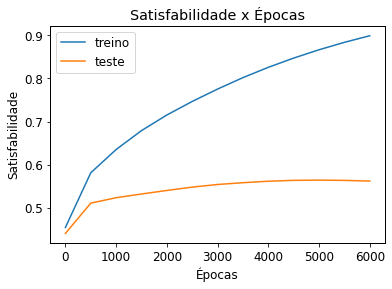

In [99]:
plt.plot(x1,y1,label='treino')
plt.plot(x2,y2,label='teste')
plt.title("Satisfabilidade x Épocas")
plt.xlabel("Épocas")
plt.ylabel("Satisfabilidade")
plt.legend()
plt.savefig('plot_satXepocas.png')
plt.show()